In [1]:

import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import tensorflow as tf
import random as rn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    balanced_accuracy_score
)
import tensorflow as tf
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
# Reproducibility
sd = 1
os.environ['PYTHONHASHSEED'] = str(sd)
np.random.seed(sd)
rn.seed(sd)
tf.random.set_seed(sd)

# Root directory containing data folders
root_dir = './Paderborn_PreCase1_Data'

# Class label structure
data_structure = {
    0: ("Healthy", ["K001", "K002", "K003", "K004", "K005"]),
    1: ("OR_Damage", ["KA04", "KA15", "KA16", "KA22", "KA30"]),
    2: ("IR_Damage", ["KI04", "KI14", "KI16", "KI18", "KI21"]),
    
}
# imbalance creation
sample_limit_per_label = {0: 256000, 1: 5120, 2: 5120}

# Extract vibration signal from .mat file
def extract_signals_df(filepath, signal="vibration"):
    signals = {"vibration": 6, "current_1": 1, "current_2": 2}
    mat = loadmat(filepath, struct_as_record=False, squeeze_me=True)
    field = next(k for k in mat if not k.startswith("__"))
    struct = mat[field]
    X_channels = struct.X
    Y_channels = struct.Y
    v = Y_channels[signals["vibration"]].Data.flatten().reshape(-1, 1)
    return pd.DataFrame(v, columns=["vibration"])

# Data extraction
all_data = {0: [], 1: [], 2: []}

for label, (category, folders) in data_structure.items():
    for folder in folders:
        folder_path = os.path.join(root_dir, folder)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} not found.")
            continue

        mat_files = [f for f in os.listdir(folder_path) if f.endswith(".mat")]
        if not mat_files:
            print(f"No .mat files found in {folder_path}")
            continue

        filename = mat_files[0]
        file_path = os.path.join(folder_path, filename)
        try:
            df = extract_signals_df(file_path, signal="vibration")
            df = df.iloc[:sample_limit_per_label[label]].copy()
            df["label"] = label
            all_data[label].append(df)
            print(f"Loaded {file_path} with {len(df)} samples.")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

# Combine all data
final_df = pd.concat([df for dfs in all_data.values() for df in dfs], ignore_index=True)
final_df.rename(columns={"vibration": "signal"}, inplace=True)
print("\nCombined data shape:", final_df.shape)
print(final_df.head())

# # Save per-label CSVs
# for label, dfs in all_data.items():
#     if dfs:
#         combined_df = pd.concat(dfs, ignore_index=True)
#         combined_df.rename(columns={"vibration": "signal"}, inplace=True)
#         out_file = f"Label{label}_{data_structure[label][0]}.csv"
#         combined_df.to_csv(out_file, index=False)
#         print(f"Exported: {out_file} with shape {combined_df.shape}")
#     else:
#         print(f"No data to export for label {label}.")

# Signal grouping
df_signals = final_df[["signal", "label"]].copy()
grouped_signals = [
    df_signals[df_signals['label'] == i]['signal'].values.astype(float)
    for i in sorted(df_signals['label'].unique())
]

Loaded ./Paderborn_PreCase1_Data/K001/N15_M07_F04_K001_13.mat with 256000 samples.
Loaded ./Paderborn_PreCase1_Data/K002/N09_M07_F10_K002_2.mat with 256000 samples.
Loaded ./Paderborn_PreCase1_Data/K003/N09_M07_F10_K003_1.mat with 256000 samples.
Loaded ./Paderborn_PreCase1_Data/K004/N09_M07_F10_K004_2.mat with 256000 samples.
Loaded ./Paderborn_PreCase1_Data/K005/N09_M07_F10_K005_1.mat with 256000 samples.
Loaded ./Paderborn_PreCase1_Data/KA04/N09_M07_F10_KA04_1.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KA15/N09_M07_F10_KA15_1.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KA16/N09_M07_F10_KA16_1.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KA22/N09_M07_F10_KA22_2.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KA30/N09_M07_F10_KA30_2.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KI04/N09_M07_F10_KI04_1.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KI14/N09_M07_F10_KI14_2.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_D

<Axes: title={'center': 'Class Distribution'}, xlabel='label'>

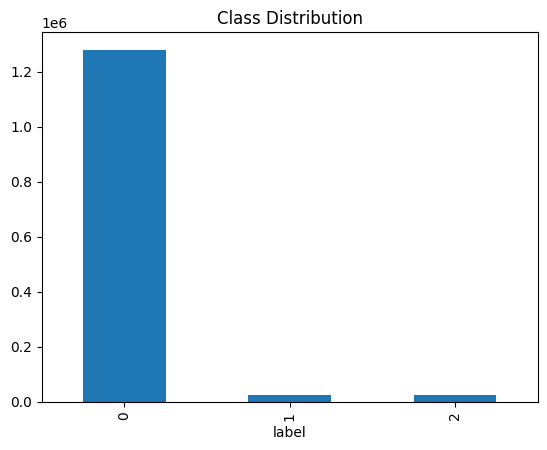

In [2]:
df_signals['label'].value_counts().plot(kind='bar', title='Class Distribution')

### Data Preparation

In [3]:
# Sampling configuration
interval_length = 320
samples_per_block = 1600


# Sampling function
def sampling(data, interval_length, samples_per_block, ignore_points=0):

    adjusted_length = len(data) - 2 * ignore_points
    num_blocks = (
        round(adjusted_length / interval_length)
        - round(samples_per_block / interval_length)
        - 1
    )
    if num_blocks <= 0:
        return np.empty((0, samples_per_block))
    split_data = np.zeros([num_blocks, samples_per_block])
    for i in range(num_blocks):
        start_idx = ignore_points + i * interval_length
        split_data[i, :] = data[start_idx : start_idx + samples_per_block].T
    return split_data

def data_preparation(data_list, interval_length, samples_per_block):
    for count, signal in enumerate(data_list):
        split_data = sampling(signal, interval_length, samples_per_block)
        if split_data.shape[0] == 0:
            continue
        y = np.zeros([len(split_data), len(data_list)])
        y[:, count] = 1
        y1 = np.zeros([len(split_data), 1])
        y1[:, 0] = count
        if count == 0:
            X = split_data
            y_positional = y
            y_labels = y1
        else:
            X = np.append(X, split_data, axis=0)
            y_positional = np.append(y_positional, y, axis=0)
            y_labels = np.append(y_labels, y1, axis=0)
    return X, y_positional, y_labels

# Run preparation
X, y_positional, y_labels = data_preparation(grouped_signals, interval_length, samples_per_block)

X.shape, y_positional.shape, y_labels.shape

((4142, 1600), (4142, 3), (4142, 1))

### Time-Based Splitting

In [ ]:
def time_series_stratified_split(X, y, train_ratio = 0.8):
    num_classes = y.shape[1]
    X_train, y_train, X_test, y_test = [], [], [], []

    for cls in range(num_classes):
        cls_indices = np.where(np.argmax(y, axis=1) == cls)[0]
        n_train = int(train_ratio * len(cls_indices))
        train_idx, test_idx = cls_indices[:n_train], cls_indices[n_train:]
        X_train.append(X[train_idx])
        # print("X_train shape:", len(X_train))
        y_train.append(y[train_idx])
        # print("y_train shape:", len(X_train))
        X_test.append(X[test_idx])
        # print("X_train shape:", len(X_train))
        y_test.append(y[test_idx])
        # print("y_test shape:", len(X_train))
        print(f"Class {cls}: Train size = {len(train_idx)}, Test size = {len(test_idx)}")


    return (
        np.concatenate(X_train),
        np.concatenate(y_train),
        np.concatenate(X_test),
        np.concatenate(y_test)
    )


In [5]:
foldername_cnn = os.path.join(os.getcwd(), "Paderborn_imbalanced_Final_Results", "1D_CNN")
foldername_cnn_lstm_attn = os.path.join(os.getcwd(), "Paderborn_imbalanced_Final_Results", "1D_CNN_LSTM_Attention")
foldername_cnn_attn = os.path.join(os.getcwd(), "Paderborn_imbalanced_Final_Results", "1D_CNN_attention")
foldername_cnn_lstm = os.path.join(os.getcwd(), "Paderborn_imbalanced_Final_Results", "1D_CNN_LSTM")

os.makedirs(foldername_cnn, exist_ok=True)
os.makedirs(foldername_cnn_lstm_attn, exist_ok=True)
os.makedirs(foldername_cnn_attn, exist_ok=True)
os.makedirs(foldername_cnn_lstm, exist_ok=True)

In [6]:
X_train, y_train, X_test, y_test = time_series_stratified_split(X, y_positional) # type: ignore

X_1D_train = X_train.reshape(-1, samples_per_block, 1) # type: ignore
X_1D_test = X_test.reshape(-1, samples_per_block, 1) # type: ignore

input_shape = (samples_per_block, 1)
y_train_classes = np.argmax(y_train, axis=1)

X_1D_train.shape, X_1D_test.shape, y_train_classes.shape

((3313, 1600, 1), (829, 1600, 1), (3313,))

In [8]:
from sklearn.model_selection import StratifiedKFold

k_split = 5
kfold = StratifiedKFold(n_splits=k_split, shuffle=False)

In [9]:

# Training with k-fold validation
class CNN_1D():
    def __init__(self):
        self.model = self.CreateModel()
        self.model.summary()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),
            
            layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(3, activation='softmax')
        ])

        # Optimizer with a slightly higher learning rate
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        model.summary()
        return model



# Metric storage
accuracy_1D_cnn, precision_1D_cnn, recall_1D_cnn, f1_1D_cnn, log_loss_1D_cnn, balanced_accuracy_1D_cnn = [], [], [], [], [], []
accuracy_1D_test_cnn, precision_1D_test_cnn, recall_1D_test_cnn, f1_1D_test_cnn, log_loss_1D_test_cnn, balanced_accuracy_1D_test_cnn = [], [], [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn, f"best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D()
    model.model.fit(
        X_1D_train[train_idx], y_train[train_idx],
        validation_data=(X_1D_train[val_idx], y_train[val_idx]),
        epochs=20,
        verbose=1,
        callbacks=[checkpoint]
    )

    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn, f"1D_CNN_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()


    print(f"Best model saved at: {checkpoint_filepath}")





Fold 1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8763 - loss: 0.3606
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN/best_model_1.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.8781 - loss: 0.3556 - val_accuracy: 0.9638 - val_loss: 0.7970
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9827 - loss: 0.0295
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9827 - loss: 0.0295 - val_accuracy: 0.9638 - val_loss: 0.8273
Epoch 3/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9931 - loss: 0.0222
Epoch 3: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9930 - loss: 0.0222 - val_accuracy: 0.0980 - val_loss: 1.0609
Epoch 4/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9929 - loss: 0.0185
Epoch 4: val_accuracy did not improve f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8774 - loss: 0.3487
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN/best_model_2.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.8783 - loss: 0.3464 - val_accuracy: 0.9638 - val_loss: 0.8501
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9848 - loss: 0.0400
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9848 - loss: 0.0400 - val_accuracy: 0.4449 - val_loss: 1.1991
Epoch 3/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9911 - loss: 0.0279
Epoch 3: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9911 - loss: 0.0279 - val_accuracy: 0.0181 - val_loss: 1.8582
Epoch 4/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9927 - loss: 0.0216
Epoch 4: val_accuracy did not improve f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7774 - loss: 0.5108
Epoch 1: val_accuracy improved from -inf to 0.01810, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN/best_model_3.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.7808 - loss: 0.5040 - val_accuracy: 0.0181 - val_loss: 1.2973
Epoch 2/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9844 - loss: 0.0424
Epoch 2: val_accuracy did not improve from 0.01810
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9843 - loss: 0.0424 - val_accuracy: 0.0181 - val_loss: 1.8536
Epoch 3/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9828 - loss: 0.0308
Epoch 3: val_accuracy did not improve from 0.01810
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9827 - loss: 0.0308 - val_accuracy: 0.0181 - val_loss: 2.4832
Epoch 4/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9856 - loss: 0.0248
Epoch 4: val_accuracy did not improve f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7654 - loss: 0.5606
Epoch 1: val_accuracy improved from -inf to 0.96224, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN/best_model_4.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7690 - loss: 0.5532 - val_accuracy: 0.9622 - val_loss: 0.9106
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9790 - loss: 0.0479
Epoch 2: val_accuracy did not improve from 0.96224
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9790 - loss: 0.0479 - val_accuracy: 0.0166 - val_loss: 1.2162
Epoch 3/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9842 - loss: 0.0364
Epoch 3: val_accuracy did not improve from 0.96224
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9842 - loss: 0.0364 - val_accuracy: 0.0166 - val_loss: 1.8556
Epoch 4/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9873 - loss: 0.0291
Epoch 4: val_accuracy did not improve f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8721 - loss: 0.3743
Epoch 1: val_accuracy improved from -inf to 0.96526, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN/best_model_5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8730 - loss: 0.3718 - val_accuracy: 0.9653 - val_loss: 0.7635
Epoch 2/20
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9831 - loss: 0.0425
Epoch 2: val_accuracy improved from 0.96526 to 0.98338, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN/best_model_5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9831 - loss: 0.0424 - val_accuracy: 0.9834 - val_loss: 0.7092
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9843 - loss: 0.0343
Epoch 3: val_accuracy did not improve from 0.98338
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9844 - loss: 0.0343 - val_accuracy: 0.9834 - val_loss: 0.5126
E

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
print("1D CNN Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn}")
print(f"Test Accuracy: {accuracy_1D_test_cnn}")
print(f"Precision: {precision_1D_test_cnn}")
print(f"Recall: {recall_1D_test_cnn}")
print(f"F1 Score: {f1_1D_test_cnn}")
print(f"Log Loss: {log_loss_1D_test_cnn}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn}")

1D CNN Metrics:
Train Accuracy: [0.99, 0.997, 0.997, 0.998, 0.729]
Test Accuracy: [0.984, 0.983, 0.984, 0.986, 0.982]
Precision: [0.981, 0.986, 0.985, 0.986, 0.97]
Recall: [0.984, 0.983, 0.984, 0.986, 0.982]
F1 Score: [0.98, 0.977, 0.978, 0.981, 0.975]
Log Loss: [0.118, 0.104, 0.198, 0.106, 0.052]
Balanced Accuracy: [0.711, 0.689, 0.711, 0.733, 0.667]


### 1D CNN + Attention Model

In [12]:
from keras import layers, models, Input
from keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Dense, GlobalAveragePooling1D, Conv1D, MaxPooling1D, BatchNormalization

class CNN_1D_Attn():
    def __init__(self, input_shape):
        self.model = self.CreateModel(input_shape)
        self.model.summary()

    def CreateModel(self, input_shape):
        inputs = Input(shape=input_shape)

        x = Conv1D(16, 3, strides=1, padding='same', activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2)(x)

        x = Conv1D(32, 3, strides=1, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2)(x)

        x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2)(x)  # Shape: (seq_len, 64)

        # Attention Layer
        x_norm = LayerNormalization()(x)
        attn_output = MultiHeadAttention(num_heads=4, key_dim=16)(x_norm, x_norm)
        x = layers.Add()([x, attn_output])  # Residual Connection
        x = LayerNormalization()(x)

        x = GlobalAveragePooling1D()(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(3, activation='softmax')(x)

        model = models.Model(inputs, output)

        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        model.summary()
        return model
    
os.makedirs(foldername_cnn_attn, exist_ok=True)

# Split the data
X_train, y_train, X_test, y_test = time_series_stratified_split(X=X, y=y_positional, train_ratio=0.8)

# Reshape for CNN input
X_1D_train = X_train.reshape([-1, samples_per_block, 1])
X_1D_test = X_test.reshape([-1, samples_per_block, 1])
input_shape = (samples_per_block, 1)

# For K-Fold
y_train_classes = np.argmax(y_train, axis=1)
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# Metric storage
accuracy_1D_cnn_attn, precision_1D_cnn_attn, recall_1D_cnn_attn, f1_1D_cnn_attn, log_loss_1D_cnn_attn, balanced_accuracy_1D_cnn_attn = [], [], [], [], [], []
accuracy_1D_test_cnn_attn, precision_1D_test_cnn_attn, recall_1D_test_cnn_attn, f1_1D_test_cnn_attn, log_loss_1D_test_cnn_attn, balanced_accuracy_1D_test_cnn_attn = [], [], [], [], [], []

# ------------------ Training Loop ------------------
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_attn, f"1D_CNN_Attention_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D_Attn(input_shape=(1600, 1))
    model.model.fit(
        X_1D_train[train_idx], y_train[train_idx],
        validation_data=(X_1D_train[val_idx], y_train[val_idx]),
        epochs=50,
        verbose=1,
        callbacks=[checkpoint]
    )
    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn_attn.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn_attn.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn_attn.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn_attn.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn_attn.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn_attn.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN + Attention Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_attn, f"1D_CNN_Attention_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn_attn.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn_attn.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn_attn.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn_attn.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn_attn.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn_attn.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN + Attention Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_attn, f"1D_CNN_Attention_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")


Fold 1


Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_20… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_20… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 3)         │        195 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,539 (115.39 KB)

 Trainable params: 29,315 (114.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_20… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_20… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 3)         │        195 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,539 (115.39 KB)

 Trainable params: 29,315 (114.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9007 - loss: 0.3144
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_attention/1D_CNN_Attention_best_model_1.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9014 - loss: 0.3123 - val_accuracy: 0.9638 - val_loss: 0.4594
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9889 - loss: 0.0245
Epoch 2: val_accuracy improved from 0.96380 to 0.98190, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_attention/1D_CNN_Attention_best_model_1.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.9888 - loss: 0.0246 - val_accuracy: 0.9819 - val_loss: 0.1434
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9899 - loss: 0.0237
Epoch 3: val_accuracy did not improve from 0.98190
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.98

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_21    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_21… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_22    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_23    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_23… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_23… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 3)         │        195 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,539 (115.39 KB)

 Trainable params: 29,315 (114.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_21    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_21… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_22    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_23    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_23… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_23… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 3)         │        195 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,539 (115.39 KB)

 Trainable params: 29,315 (114.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9556 - loss: 0.2262
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_attention/1D_CNN_Attention_best_model_2.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.9559 - loss: 0.2249 - val_accuracy: 0.9638 - val_loss: 0.1615
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9824 - loss: 0.0596
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9824 - loss: 0.0596 - val_accuracy: 0.0181 - val_loss: 3.7508
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9822 - loss: 0.0491
Epoch 3: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.9822 - loss: 0.0491 - val_accuracy: 0.0181 - val_loss: 5.1582
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9854 - loss: 0.0273
Epoch 

Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_24    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_24… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_26    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_26… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_26… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 3)         │        195 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,539 (115.39 KB)

 Trainable params: 29,315 (114.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_24    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_24… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_26    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_26… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_26… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 3)         │        195 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,539 (115.39 KB)

 Trainable params: 29,315 (114.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9386 - loss: 0.2858
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_attention/1D_CNN_Attention_best_model_3.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.9390 - loss: 0.2841 - val_accuracy: 0.9638 - val_loss: 0.3846
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9873 - loss: 0.0465
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.9873 - loss: 0.0465 - val_accuracy: 0.9638 - val_loss: 0.1328
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9826 - loss: 0.0331
Epoch 3: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.9826 - loss: 0.0331 - val_accuracy: 0.9532 - val_loss: 0.5368
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9870 - loss: 0.0242
Epoch

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_27    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_27… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_28    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_28… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_29    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_29… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_29… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 3)         │        195 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,539 (115.39 KB)

 Trainable params: 29,315 (114.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_27    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_27… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_28    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_28… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_29    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_29… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_29… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 3)         │        195 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,539 (115.39 KB)

 Trainable params: 29,315 (114.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9168 - loss: 0.3149
Epoch 1: val_accuracy improved from -inf to 0.01813, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_attention/1D_CNN_Attention_best_model_4.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.9173 - loss: 0.3129 - val_accuracy: 0.0181 - val_loss: 3.7938
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9809 - loss: 0.0441
Epoch 2: val_accuracy did not improve from 0.01813
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9810 - loss: 0.0440 - val_accuracy: 0.0181 - val_loss: 4.8803
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9832 - loss: 0.0352
Epoch 3: val_accuracy did not improve from 0.01813
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.9832 - loss: 0.0352 - val_accuracy: 0.0181 - val_loss: 4.8542
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9849 - loss: 0.0333
Epoch 4:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_32    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_32… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_32… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 3)         │        195 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,539 (115.39 KB)

 Trainable params: 29,315 (114.51 KB)

 Non-trainable params: 224 (896.00 B)

Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1600, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 1600, 16)  │         64 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1600, 16)  │         64 │ conv1d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 800, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 800, 32)   │      1,568 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 400, 64)   │      6,208 │ max_pooling1d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_32    │ (None, 200, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_32… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 200, 64)   │          0 │ max_pooling1d_32… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 3)         │        195 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 29,539 (115.39 KB)

 Trainable params: 29,315 (114.51 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.2795
Epoch 1: val_accuracy improved from -inf to 0.96526, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_attention/1D_CNN_Attention_best_model_5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9400 - loss: 0.2778 - val_accuracy: 0.9653 - val_loss: 0.2231
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9798 - loss: 0.0523
Epoch 2: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9798 - loss: 0.0522 - val_accuracy: 0.0181 - val_loss: 5.5613
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9853 - loss: 0.0382
Epoch 3: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9854 - loss: 0.0381 - val_accuracy: 0.0181 - val_loss: 7.3866
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9837 - loss: 0.0302
Epoch 4: val

In [13]:
print("1D CNN+Attention Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn_attn}")
print(f"Test Accuracy: {accuracy_1D_test_cnn_attn}")
print(f"Precision: {precision_1D_test_cnn_attn}")
print(f"Recall: {recall_1D_test_cnn_attn}")
print(f"F1 Score: {f1_1D_test_cnn_attn}")
print(f"Log Loss: {log_loss_1D_test_cnn_attn}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn_attn}")

1D CNN+Attention Metrics:
Train Accuracy: [1.0, 0.996, 1.0, 1.0, 0.996]
Test Accuracy: [0.987, 0.967, 0.978, 0.982, 0.982]
Precision: [0.987, 0.963, 0.969, 0.964, 0.976]
Recall: [0.987, 0.967, 0.978, 0.982, 0.982]
F1 Score: [0.983, 0.964, 0.973, 0.973, 0.977]
Log Loss: [0.201, 0.175, 0.183, 0.226, 0.116]
Balanced Accuracy: [0.756, 0.683, 0.6, 0.667, 0.667]


### 1D CNN + LSTM Model

In [14]:
class CNN_LSTM_1D():
    def __init__(self):
        self.model = self.build_model()
        self.model.summary()

    def build_model(self):
        from keras.layers import Reshape, multiply, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input
        from keras.models import Model

        input_seq = Input(shape=(1600,))
        X = Reshape((1600, 1))(input_seq)

        ec1_layer1 = Conv1D(50, 20, strides=2, activation='relu')(X)
        ec1_layer2 = Conv1D(30, 10, strides=2, activation='relu')(ec1_layer1)
        ec1_outputs = MaxPooling1D(pool_size=2)(ec1_layer2)

        ec2_layer1 = Conv1D(50, 8, strides=2, activation='relu')(X)
        ec2_layer2 = Conv1D(40, 6, strides=2, activation='relu')(ec2_layer1)
        ec2_layer3 = MaxPooling1D(pool_size=2)(ec2_layer2)
        ec2_layer4 = Conv1D(30, 4, strides=1, activation='relu')(ec2_layer3)
        ec2_outputs = ec2_layer4

        encoder = multiply([ec1_outputs, ec2_outputs])

        x = LSTM(60, return_sequences=True)(encoder)
        x = LSTM(60)(x)
        x = Dropout(0.5)(x)
        output = Dense(3, activation='softmax')(x)

        model = Model(input_seq, output)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.summary()
        return model

# Create directory for CNN + LSTM results
os.makedirs(foldername_cnn_lstm, exist_ok=True)

# Split the data
X_train, y_train, X_test, y_test = time_series_stratified_split(X=X, y=y_positional, train_ratio=0.8)

y_train_classes = np.argmax(y_train, axis=1)

# Metric storage
accuracy_1D_cnn_lstm, precision_1D_cnn_lstm, recall_1D_cnn_lstm, f1_1D_cnn_lstm, log_loss_1D_cnn_lstm, balanced_accuracy_1D_cnn_lstm = [], [], [], [], [], []
accuracy_1D_test_cnn_lstm, precision_1D_test_cnn_lstm, recall_1D_test_cnn_lstm, f1_1D_test_cnn_lstm, log_loss_1D_test_cnn_lstm, balanced_accuracy_1D_test_cnn_lstm = [], [], [], [], [], []

# ------------------ Training Loop ------------------
# for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_lstm, f"1D_CNN_LSTM_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_LSTM_1D()
    model.model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=20,
        verbose=1,
        callbacks=[checkpoint]
    )

    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn_lstm.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn_lstm.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn_lstm.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn_lstm.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn_lstm.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn_lstm.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN + LSTM Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm, f"1D_CNN_LSTM_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn_lstm.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn_lstm.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn_lstm.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn_lstm.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn_lstm.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn_lstm.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN + LSTM Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm, f"1D_CNN_LSTM_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")





Fold 1


Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1600, 1)   │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 198, 40)   │          0 │ conv1d_36[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 195, 30)   │          0 │ conv1d_34[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_34… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 195, 30)   │          0 │ max_pooling1d_33… │
│                     │                   │            │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 195, 60)   │     21,840 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 60)        │     29,040 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 60)        │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 3)         │        183 │ dropout_22[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,463 (329.93 KB)

 Trainable params: 84,463 (329.93 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1600, 1)   │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 198, 40)   │          0 │ conv1d_36[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 195, 30)   │          0 │ conv1d_34[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_34… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 195, 30)   │          0 │ max_pooling1d_33… │
│                     │                   │            │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 195, 60)   │     21,840 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 60)        │     29,040 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 60)        │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 3)         │        183 │ dropout_22[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,463 (329.93 KB)

 Trainable params: 84,463 (329.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9437 - loss: 0.4925
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM/1D_CNN_LSTM_best_model_1.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9439 - loss: 0.4901 - val_accuracy: 0.9638 - val_loss: 0.1713
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9692 - loss: 0.1412
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9692 - loss: 0.1409 - val_accuracy: 0.9638 - val_loss: 0.1342
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9833 - loss: 0.0518
Epoch 3: val_accuracy improved from 0.96380 to 0.97436, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM/1D_CNN_LSTM_best_model_1.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9832 - loss: 0.0519 - val_a

Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_38[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 198, 40)   │          0 │ conv1d_41[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_35    │ (None, 195, 30)   │          0 │ conv1d_39[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_36… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 195, 30)   │          0 │ max_pooling1d_35… │
│ (Multiply)          │                   │            │ conv1d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 60)        │     29,040 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 60)        │          0 │ lstm_3[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 3)         │        183 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,463 (329.93 KB)

 Trainable params: 84,463 (329.93 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_38[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 198, 40)   │          0 │ conv1d_41[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_35    │ (None, 195, 30)   │          0 │ conv1d_39[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_36… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 195, 30)   │          0 │ max_pooling1d_35… │
│ (Multiply)          │                   │            │ conv1d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 60)        │     29,040 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 60)        │          0 │ lstm_3[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 3)         │        183 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,463 (329.93 KB)

 Trainable params: 84,463 (329.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9173 - loss: 0.4960
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM/1D_CNN_LSTM_best_model_2.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9178 - loss: 0.4937 - val_accuracy: 0.9638 - val_loss: 0.1771
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9680 - loss: 0.1636
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9679 - loss: 0.1636 - val_accuracy: 0.9638 - val_loss: 0.0673
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9687 - loss: 0.1080
Epoch 3: val_accuracy improved from 0.96380 to 0.98039, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM/1D_CNN_LSTM_best_model_2.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9687 - loss: 0.1079 - val_a

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_38    │ (None, 198, 40)   │          0 │ conv1d_46[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 195, 30)   │          0 │ conv1d_44[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_38… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 195, 30)   │          0 │ max_pooling1d_37… │
│ (Multiply)          │                   │            │ conv1d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 60)        │     29,040 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 60)        │          0 │ lstm_5[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 3)         │        183 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,463 (329.93 KB)

 Trainable params: 84,463 (329.93 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_38    │ (None, 198, 40)   │          0 │ conv1d_46[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 195, 30)   │          0 │ conv1d_44[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_38… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 195, 30)   │          0 │ max_pooling1d_37… │
│ (Multiply)          │                   │            │ conv1d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 60)        │     29,040 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 60)        │          0 │ lstm_5[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 3)         │        183 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,463 (329.93 KB)

 Trainable params: 84,463 (329.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9192 - loss: 0.5079
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM/1D_CNN_LSTM_best_model_3.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9196 - loss: 0.5053 - val_accuracy: 0.9638 - val_loss: 0.1724
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9685 - loss: 0.1533
Epoch 2: val_accuracy improved from 0.96380 to 0.97888, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM/1D_CNN_LSTM_best_model_3.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9685 - loss: 0.1531 - val_accuracy: 0.9789 - val_loss: 0.0790
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9762 - loss: 0.0749
Epoch 3: val_accuracy improved from 0.97888 to 0.98190, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalance

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_50[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_48[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_40    │ (None, 198, 40)   │          0 │ conv1d_51[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_39    │ (None, 195, 30)   │          0 │ conv1d_49[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_40… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 195, 30)   │          0 │ max_pooling1d_39… │
│ (Multiply)          │                   │            │ conv1d_52[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 60)        │     29,040 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 60)        │          0 │ lstm_7[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 3)         │        183 │ dropout_25[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,463 (329.93 KB)

 Trainable params: 84,463 (329.93 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_50[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_48[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_40    │ (None, 198, 40)   │          0 │ conv1d_51[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_39    │ (None, 195, 30)   │          0 │ conv1d_49[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_40… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 195, 30)   │          0 │ max_pooling1d_39… │
│ (Multiply)          │                   │            │ conv1d_52[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 60)        │     29,040 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 60)        │          0 │ lstm_7[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 3)         │        183 │ dropout_25[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,463 (329.93 KB)

 Trainable params: 84,463 (329.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9050 - loss: 0.5194
Epoch 1: val_accuracy improved from -inf to 0.96526, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM/1D_CNN_LSTM_best_model_4.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9056 - loss: 0.5168 - val_accuracy: 0.9653 - val_loss: 0.1762
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9615 - loss: 0.1999
Epoch 2: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9616 - loss: 0.1998 - val_accuracy: 0.9653 - val_loss: 0.1696
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9620 - loss: 0.1645
Epoch 3: val_accuracy improved from 0.96526 to 0.97885, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM/1D_CNN_LSTM_best_model_4.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9621 - loss: 0.1640 - val_a

Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_55[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_53[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_42    │ (None, 198, 40)   │          0 │ conv1d_56[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_41    │ (None, 195, 30)   │          0 │ conv1d_54[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_42… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 195, 30)   │          0 │ max_pooling1d_41… │
│ (Multiply)          │                   │            │ conv1d_57[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 60)        │     29,040 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 60)        │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 3)         │        183 │ dropout_26[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,463 (329.93 KB)

 Trainable params: 84,463 (329.93 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 797, 50)   │        450 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 791, 50)   │      1,050 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 396, 40)   │     12,040 │ conv1d_55[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 391, 30)   │     15,030 │ conv1d_53[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_42    │ (None, 198, 40)   │          0 │ conv1d_56[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_41    │ (None, 195, 30)   │          0 │ conv1d_54[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 195, 30)   │      4,830 │ max_pooling1d_42… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 195, 30)   │          0 │ max_pooling1d_41… │
│ (Multiply)          │                   │            │ conv1d_57[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 195, 60)   │     21,840 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 60)        │     29,040 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 60)        │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 3)         │        183 │ dropout_26[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,463 (329.93 KB)

 Trainable params: 84,463 (329.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9069 - loss: 0.5315
Epoch 1: val_accuracy improved from -inf to 0.96526, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM/1D_CNN_LSTM_best_model_5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9075 - loss: 0.5289 - val_accuracy: 0.9653 - val_loss: 0.1755
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9615 - loss: 0.2054
Epoch 2: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9616 - loss: 0.2053 - val_accuracy: 0.9653 - val_loss: 0.1506
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9638 - loss: 0.1433
Epoch 3: val_accuracy improved from 0.96526 to 0.98187, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM/1D_CNN_LSTM_best_model_5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9639 - loss: 0.1428 - val_a

In [15]:
print("1D CNN+LSTM Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn_lstm}")
print(f"Test Accuracy: {accuracy_1D_test_cnn_lstm}")
print(f"Precision: {precision_1D_test_cnn_lstm}")
print(f"Recall: {recall_1D_test_cnn_lstm}")
print(f"F1 Score: {f1_1D_test_cnn_lstm}")
print(f"Log Loss: {log_loss_1D_test_cnn_lstm}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn_lstm}")


1D CNN+LSTM Metrics:
Train Accuracy: [0.989, 0.986, 0.983, 0.985, 0.986]
Test Accuracy: [0.972, 0.969, 0.967, 0.976, 0.972]
Precision: [0.969, 0.964, 0.967, 0.973, 0.972]
Recall: [0.972, 0.969, 0.967, 0.976, 0.972]
F1 Score: [0.968, 0.963, 0.961, 0.972, 0.968]
Log Loss: [0.196, 0.146, 0.162, 0.152, 0.144]
Balanced Accuracy: [0.489, 0.422, 0.4, 0.556, 0.489]


### 1D CNN + LSTM + ATTENTION

In [16]:
## Model 2
from keras import layers, Model, Input
from keras.layers import (
    Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Bidirectional,
    BatchNormalization, LayerNormalization, MultiHeadAttention,
    Reshape, Concatenate, Add, Activation
)
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

class CNN_1D_LSTM_Attention():
    def __init__(self):
        self.model = self.build_model()
        self.model.summary()

    def build_model(self):
        input_seq = Input(shape=(1600,))
        X = Reshape((1600, 1))(input_seq)

        # CNN Branch 1
        branch1 = Conv1D(32, 10, strides=2, padding='same')(X)  # (800, 32)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = Conv1D(16, 5, strides=2, padding='same')(branch1)  # (400, 16)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = MaxPooling1D(pool_size=2)(branch1)  # (200, 16)

        # Residual shortcut
        shortcut1 = Conv1D(16, 1, strides=4, padding='same')(X)  # (400, 16)
        shortcut1 = MaxPooling1D(pool_size=2)(shortcut1)  # (200, 16)
        branch1 = Add()([branch1, shortcut1])  # (200, 16)

        # CNN Branch 2
        branch2 = Conv1D(32, 6, strides=2, padding='same')(X)  # (800, 32)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = Conv1D(16, 3, strides=2, padding='same')(branch2)  # (400, 16)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = MaxPooling1D(pool_size=2)(branch2)  # (200, 16)

        # Merge branches
        combined = Concatenate(axis=-1)([branch1, branch2])  # (200, 32)
        combined = LayerNormalization()(combined)

        # Multi-head attention
        attn_out = MultiHeadAttention(num_heads=4, key_dim=8)(combined, combined)
        attn_out = LayerNormalization()(attn_out)

        # Bidirectional LSTM
        x = Bidirectional(LSTM(32, return_sequences=True))(attn_out)
        x = Bidirectional(LSTM(32))(x)

        # Fully connected layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)

        # Final model
        model = Model(input_seq, output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        model.summary()

        # Learning rate scheduler
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        self.callbacks = [lr_scheduler]

        return model

os.makedirs(foldername_cnn_lstm_attn, exist_ok=True)

# For K-Fold
y_train_classes = np.argmax(y_train, axis=1)
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# Metric storage
accuracy_1D_cnn_lstm_attn, precision_1D_cnn_lstm_attn, recall_1D_cnn_lstm_attn, f1_1D_cnn_lstm_attn, log_loss_1D_cnn_lstm_attn, balanced_accuracy_1D_cnn_lstm_attn = [], [], [], [], [], []
accuracy_1D_test_cnn_lstm_attn, precision_1D_test_cnn_lstm_attn, recall_1D_test_cnn_lstm_attn, f1_1D_test_cnn_lstm_attn, log_loss_1D_test_cnn_lstm_attn, balanced_accuracy_1D_test_cnn_lstm_attn = [], [], [], [], [], []

# ------------------ Training Loop ------------------
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_lstm_attn, f"1D_CNN_LSTM_Attention_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D_LSTM_Attention()
    model.model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=50,
        verbose=1,
        callbacks=[checkpoint]
    )
    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D_cnn_lstm_attn.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    precision_1D_cnn_lstm_attn.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    recall_1D_cnn_lstm_attn.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    f1_1D_cnn_lstm_attn.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    log_loss_1D_cnn_lstm_attn.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    balanced_accuracy_1D_cnn_lstm_attn.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'1D CNN + LSTM + Attention Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"1D_CNN_LSTM_Attention_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test_cnn_lstm_attn.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    precision_1D_test_cnn_lstm_attn.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    recall_1D_test_cnn_lstm_attn.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    f1_1D_test_cnn_lstm_attn.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    log_loss_1D_test_cnn_lstm_attn.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    balanced_accuracy_1D_test_cnn_lstm_attn.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'1D CNN + LSTM + Attention Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"1D_CNN_LSTM_Attention_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")


Fold 1


Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_61[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_62[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_43    │ (None, 200, 16)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 200, 16)   │          0 │ conv1d_60[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_43… │
│                     │                   │            │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_45    │ (None, 200, 16)   │          0 │ activation_3[0][

 Total params: 55,299 (216.01 KB)

 Trainable params: 55,107 (215.26 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_61[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_62[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_43    │ (None, 200, 16)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 200, 16)   │          0 │ conv1d_60[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_43… │
│                     │                   │            │ max_pooling1d_44… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_45    │ (None, 200, 16)   │          0 │ activation_3[0][

 Total params: 55,299 (216.01 KB)

 Trainable params: 55,107 (215.26 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9107 - loss: 0.6984
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_1.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.9112 - loss: 0.6959 - val_accuracy: 0.9638 - val_loss: 0.2535
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9739 - loss: 0.1810
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.9740 - loss: 0.1807 - val_accuracy: 0.9638 - val_loss: 0.2369
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9878 - loss: 0.1054
Epoch 3: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9877 - loss: 0.1054 - val_accuracy: 0.9638 - val_loss: 0.2470
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9846 - loss: 

Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_63[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_64[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_67[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_46    │ (None, 200, 16)   │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_47    │ (None, 200, 16)   │          0 │ conv1d_65[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_46… │
│                     │                   │            │ max_pooling1d_47… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_48    │ (None, 200, 16)   │          0 │ activation_7[0][

 Total params: 55,299 (216.01 KB)

 Trainable params: 55,107 (215.26 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_63[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_64[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_67[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_46    │ (None, 200, 16)   │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_47    │ (None, 200, 16)   │          0 │ conv1d_65[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_46… │
│                     │                   │            │ max_pooling1d_47… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_48    │ (None, 200, 16)   │          0 │ activation_7[0][

 Total params: 55,299 (216.01 KB)

 Trainable params: 55,107 (215.26 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9022 - loss: 0.7476
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_2.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.9027 - loss: 0.7452 - val_accuracy: 0.9638 - val_loss: 0.2915
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9687 - loss: 0.2281
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.9687 - loss: 0.2278 - val_accuracy: 0.9638 - val_loss: 0.2419
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9789 - loss: 0.1357
Epoch 3: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.9789 - loss: 0.1357 - val_accuracy: 0.9638 - val_loss: 0.2563
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9819 - loss: 

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_72[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_49    │ (None, 200, 16)   │          0 │ activation_9[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_50    │ (None, 200, 16)   │          0 │ conv1d_70[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_49… │
│                     │                   │            │ max_pooling1d_50… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_51    │ (None, 200, 16)   │          0 │ activation_11[0]

 Total params: 55,299 (216.01 KB)

 Trainable params: 55,107 (215.26 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_72[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_49    │ (None, 200, 16)   │          0 │ activation_9[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_50    │ (None, 200, 16)   │          0 │ conv1d_70[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_49… │
│                     │                   │            │ max_pooling1d_50… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_51    │ (None, 200, 16)   │          0 │ activation_11[0]

 Total params: 55,299 (216.01 KB)

 Trainable params: 55,107 (215.26 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8816 - loss: 0.7072
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_3.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.8822 - loss: 0.7048 - val_accuracy: 0.9638 - val_loss: 0.2596
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9744 - loss: 0.1827
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.9744 - loss: 0.1825 - val_accuracy: 0.9638 - val_loss: 0.2261
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9813 - loss: 0.1274
Epoch 3: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.9813 - loss: 0.1274 - val_accuracy: 0.9638 - val_loss: 0.1820
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9855 - loss: 

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_73[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_76[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_74[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_77[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_52    │ (None, 200, 16)   │          0 │ activation_13[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_53    │ (None, 200, 16)   │          0 │ conv1d_75[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_52… │
│                     │                   │            │ max_pooling1d_53… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_54    │ (None, 200, 16)   │          0 │ activation_15[0]

 Total params: 55,299 (216.01 KB)

 Trainable params: 55,107 (215.26 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_73[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_76[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_74[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_77[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_52    │ (None, 200, 16)   │          0 │ activation_13[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_53    │ (None, 200, 16)   │          0 │ conv1d_75[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 200, 16)   │          0 │ max_pooling1d_52… │
│                     │                   │            │ max_pooling1d_53… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_54    │ (None, 200, 16)   │          0 │ activation_15[0]

 Total params: 55,299 (216.01 KB)

 Trainable params: 55,107 (215.26 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8385 - loss: 0.8081
Epoch 1: val_accuracy improved from -inf to 0.96526, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_4.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.8396 - loss: 0.8056 - val_accuracy: 0.9653 - val_loss: 0.2621
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9642 - loss: 0.2273
Epoch 2: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.9643 - loss: 0.2269 - val_accuracy: 0.9653 - val_loss: 0.2177
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9766 - loss: 0.1418
Epoch 3: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9766 - loss: 0.1418 - val_accuracy: 0.9653 - val_loss: 0.1886
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9792 - loss: 

Model: "functional_85"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_81 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_81[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_79[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_82 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_80 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_82[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_55    │ (None, 200, 16)   │          0 │ activation_17[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_56    │ (None, 200, 16)   │          0 │ conv1d_80[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 200, 16)   │          0 │ max_pooling1d_55… │
│                     │                   │            │ max_pooling1d_56… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_57    │ (None, 200, 16)   │          0 │ activation_19[0]

 Total params: 55,299 (216.01 KB)

 Trainable params: 55,107 (215.26 KB)

 Non-trainable params: 192 (768.00 B)

Model: "functional_85"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1600, 1)   │          0 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 800, 32)   │        352 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_81 (Conv1D)  │ (None, 800, 32)   │        224 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 32)   │        128 │ conv1d_81[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 400, 16)   │      2,576 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 800, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_79[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_82 (Conv1D)  │ (None, 400, 16)   │      1,552 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_80 (Conv1D)  │ (None, 400, 16)   │         32 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 16)   │         64 │ conv1d_82[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_55    │ (None, 200, 16)   │          0 │ activation_17[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_56    │ (None, 200, 16)   │          0 │ conv1d_80[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 400, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 200, 16)   │          0 │ max_pooling1d_55… │
│                     │                   │            │ max_pooling1d_56… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_57    │ (None, 200, 16)   │          0 │ activation_19[0]

 Total params: 55,299 (216.01 KB)

 Trainable params: 55,107 (215.26 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8724 - loss: 0.8411
Epoch 1: val_accuracy improved from -inf to 0.96526, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM_Attention/1D_CNN_LSTM_Attention_best_model_5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.8732 - loss: 0.8388 - val_accuracy: 0.9653 - val_loss: 0.3184
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9628 - loss: 0.2619
Epoch 2: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.9628 - loss: 0.2614 - val_accuracy: 0.9653 - val_loss: 0.2130
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9792 - loss: 0.1422
Epoch 3: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.9792 - loss: 0.1421 - val_accuracy: 0.9653 - val_loss: 0.1630
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9823 - loss:

In [17]:
print("1D CNN+LSTM+ATTENTION Metrics:")
print(f"Train Accuracy: {accuracy_1D_cnn_lstm_attn}")
print(f"Test Accuracy: {accuracy_1D_test_cnn_lstm_attn}")
print(f"Precision: {precision_1D_test_cnn_lstm_attn}")
print(f"Recall: {recall_1D_test_cnn_lstm_attn}")
print(f"F1 Score: {f1_1D_test_cnn_lstm_attn}")
print(f"Log Loss: {log_loss_1D_test_cnn_lstm_attn}")
print(f"Balanced Accuracy: {balanced_accuracy_1D_test_cnn_lstm_attn}")

1D CNN+LSTM+ATTENTION Metrics:
Train Accuracy: [0.989, 0.998, 0.996, 0.998, 0.997]
Test Accuracy: [0.978, 0.987, 0.983, 0.986, 0.984]
Precision: [0.974, 0.987, 0.983, 0.986, 0.985]
Recall: [0.978, 0.987, 0.983, 0.986, 0.984]
F1 Score: [0.975, 0.983, 0.976, 0.981, 0.978]
Log Loss: [0.104, 0.119, 0.145, 0.1, 0.131]
Balanced Accuracy: [0.6, 0.756, 0.689, 0.733, 0.711]


### Modified Model

In [18]:
## Model 2
from keras import layers, Model, Input
from keras.layers import (
    Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Bidirectional,
    BatchNormalization, LayerNormalization, MultiHeadAttention,
    Reshape, Concatenate, Add, Activation
)
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

class CNN_1D_LSTM_Attn_Modified():
    def __init__(self):
        self.model = self.build_model()
        self.model.summary()

    def build_model(self):
        input_seq = Input(shape=(1600,))
        X = Reshape((1600, 1))(input_seq)

        # CNN Branch 1
        branch1 = Conv1D(64, 10, strides=2, padding='same')(X)  # (800, 32)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = Conv1D(64, 5, strides=2, padding='same')(branch1)  # (400, 16)
        branch1 = BatchNormalization()(branch1)
        branch1 = Activation('relu')(branch1)
        branch1 = MaxPooling1D(pool_size=2)(branch1)  # (200, 16)

        # Residual shortcut
        shortcut1 = Conv1D(64, 1, strides=4, padding='same')(X)  # (400, 16)
        shortcut1 = MaxPooling1D(pool_size=2)(shortcut1)  # (200, 16)
        branch1 = Add()([branch1, shortcut1])  # (200, 16)

        # CNN Branch 2
        branch2 = Conv1D(64, 6, strides=2, padding='same')(X)  # (800, 32)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = Conv1D(32, 3, strides=2, padding='same')(branch2)  # (400, 16)
        branch2 = BatchNormalization()(branch2)
        branch2 = Activation('relu')(branch2)
        branch2 = MaxPooling1D(pool_size=2)(branch2)  # (200, 16)

        # Merge branches
        combined = Concatenate(axis=-1)([branch1, branch2])  # (200, 32)
        combined = LayerNormalization()(combined)

        # Multi-head attention
        attn_out = MultiHeadAttention(num_heads=4, key_dim=8)(combined, combined)
        attn_out = LayerNormalization()(attn_out)

        # Bidirectional LSTM
        x = Bidirectional(LSTM(32, return_sequences=True))(attn_out)
        x = Bidirectional(LSTM(32))(x)

        # Fully connected layers
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        output = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)

        # Final model
        model = Model(input_seq, output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        model.summary()

        # # Learning rate scheduler
        # lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        # self.callbacks = [lr_scheduler]

        return model

os.makedirs(foldername_cnn_lstm_attn, exist_ok=True)

# For K-Fold
y_train_classes = np.argmax(y_train, axis=1)
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# Metric storage
mod_accuracy_1D, mod_precision_1D, mod_recall_1D, mod_f1_1D, mod_log_loss_1D, mod_balanced_accuracy_1D = [], [], [], [], [], []
mod_accuracy_1D_test, mod_precision_1D_test, mod_recall_1D_test, mod_f1_1D_test, mod_log_loss_1D_test, mod_balanced_accuracy_1D_test = [], [], [], [], [], []

# ------------------ Training Loop ------------------
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername_cnn_lstm_attn, f"modified_1D_CNN_LSTM_Attention_best_model_{fold + 1}.keras")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D_LSTM_Attn_Modified()
    model.model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=50,
        verbose=1,
        callbacks=[checkpoint]
    )
    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train_probs = best_model.predict(X_1D_train[train_idx])
    y_pred_train = np.argmax(y_pred_train_probs, axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    mod_accuracy_1D.append(round(accuracy_score(y_true_train, y_pred_train), 3))
    mod_precision_1D.append(round(precision_score(y_true_train, y_pred_train, average='weighted'), 3))
    mod_recall_1D.append(round(recall_score(y_true_train, y_pred_train, average='weighted'), 3))
    mod_f1_1D.append(round(f1_score(y_true_train, y_pred_train, average='weighted'), 3))
    mod_log_loss_1D.append(round(log_loss(y_true_train, y_pred_train_probs), 3))
    mod_balanced_accuracy_1D.append(round(balanced_accuracy_score(y_true_train, y_pred_train), 3))


    # Save confusion matrix for train
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Modified_1D CNN + LSTM + Attention Train Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"Modified_1D_CNN_LSTM_Attention_conf_matrix_train_fold_{fold + 1}.png"))
    plt.close()

    # Fixed test set evaluation
    y_pred_test_probs = best_model.predict(X_1D_test)
    y_pred_test = np.argmax(y_pred_test_probs, axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    mod_accuracy_1D_test.append(round(accuracy_score(y_true_test, y_pred_test), 3))
    mod_precision_1D_test.append(round(precision_score(y_true_test, y_pred_test, average='weighted'), 3))
    mod_recall_1D_test.append(round(recall_score(y_true_test, y_pred_test, average='weighted'), 3))
    mod_f1_1D_test.append(round(f1_score(y_true_test, y_pred_test, average='weighted'), 3))
    mod_log_loss_1D_test.append(round(log_loss(y_true_test, y_pred_test_probs), 3))
    mod_balanced_accuracy_1D_test.append(round(balanced_accuracy_score(y_true_test, y_pred_test), 3))

    # Save confusion matrix for test
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Greens')
    plt.title(f'Modified_1D CNN + LSTM + Attention Test Confusion Matrix - Fold {fold + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(foldername_cnn_lstm_attn, f"Modified_1D_CNN_LSTM_Attention_conf_matrix_test_fold_{fold + 1}.png"))
    plt.close()

    print(f"Best model saved at: {checkpoint_filepath}")


Fold 1


Model: "functional_86"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1600, 1)   │          0 │ input_layer_21[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_83 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_83[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_86 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_86[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_84 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_84[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_87 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_22[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_85 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_87[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_58    │ (None, 200, 64)   │          0 │ activation_21[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_59    │ (None, 200, 64)   │          0 │ conv1d_85[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_58… │
│                     │                   │            │ max_pooling1d_59… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,971 (406.14 KB)

 Trainable params: 103,523 (404.39 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_86"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1600, 1)   │          0 │ input_layer_21[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_83 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_83[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_86 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_86[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_84 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_84[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_87 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_22[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_85 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_87[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_58    │ (None, 200, 64)   │          0 │ activation_21[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_59    │ (None, 200, 64)   │          0 │ conv1d_85[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_58… │
│                     │                   │            │ max_pooling1d_59… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,971 (406.14 KB)

 Trainable params: 103,523 (404.39 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7317 - loss: 0.8390
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_1.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.7336 - loss: 0.8358 - val_accuracy: 0.9638 - val_loss: 0.2574
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9862 - loss: 0.1789
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.9862 - loss: 0.1786 - val_accuracy: 0.9638 - val_loss: 0.2219
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9808 - loss: 0.1109
Epoch 3: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 194ms/step - accuracy: 0.9808 - loss: 0.1109 - val_accuracy: 0.9638 - val_loss: 0.2125
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.985

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Best model saved at: /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_1.keras

Fold 2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_11          │ (None, 1600, 1)   │          0 │ input_layer_22[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_88 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_88[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_91 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_91[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_89 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_89[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_92 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_90 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_92[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_61    │ (None, 200, 64)   │          0 │ activation_25[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_62    │ (None, 200, 64)   │          0 │ conv1d_90[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_61… │
│                     │                   │            │ max_pooling1d_62… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,971 (406.14 KB)

 Trainable params: 103,523 (404.39 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_11          │ (None, 1600, 1)   │          0 │ input_layer_22[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_88 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_88[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_91 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_91[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_89 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_89[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_92 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_90 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_92[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_61    │ (None, 200, 64)   │          0 │ activation_25[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_62    │ (None, 200, 64)   │          0 │ conv1d_90[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_61… │
│                     │                   │            │ max_pooling1d_62… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,971 (406.14 KB)

 Trainable params: 103,523 (404.39 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8907 - loss: 0.6761
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_2.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.8914 - loss: 0.6737 - val_accuracy: 0.9638 - val_loss: 0.2591
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9803 - loss: 0.1729
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.9803 - loss: 0.1726 - val_accuracy: 0.9638 - val_loss: 0.2165
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9826 - loss: 0.1170
Epoch 3: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - accuracy: 0.9826 - loss: 0.1170 - val_accuracy: 0.9638 - val_loss: 0.2116
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.987

Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1600, 1)   │          0 │ input_layer_23[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_93 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_93[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_96 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_96[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_94 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_94[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_97 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_95 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_97[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_64    │ (None, 200, 64)   │          0 │ activation_29[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_65    │ (None, 200, 64)   │          0 │ conv1d_95[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_64… │
│                     │                   │            │ max_pooling1d_65… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,971 (406.14 KB)

 Trainable params: 103,523 (404.39 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1600, 1)   │          0 │ input_layer_23[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_93 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_93[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_96 (Conv1D)  │ (None, 800, 64)   │        448 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_96[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_94 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_94[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_97 (Conv1D)  │ (None, 400, 32)   │      6,176 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_95 (Conv1D)  │ (None, 400, 64)   │        128 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_97[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_64    │ (None, 200, 64)   │          0 │ activation_29[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_65    │ (None, 200, 64)   │          0 │ conv1d_95[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_64… │
│                     │                   │            │ max_pooling1d_65… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,971 (406.14 KB)

 Trainable params: 103,523 (404.39 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8153 - loss: 0.8294
Epoch 1: val_accuracy improved from -inf to 0.96380, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_3.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.8165 - loss: 0.8267 - val_accuracy: 0.9638 - val_loss: 0.3118
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9797 - loss: 0.2458
Epoch 2: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - accuracy: 0.9797 - loss: 0.2455 - val_accuracy: 0.9638 - val_loss: 0.2264
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9801 - loss: 0.1539
Epoch 3: val_accuracy did not improve from 0.96380
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 205ms/step - accuracy: 0.9801 - loss: 0.1538 - val_accuracy: 0.9638 - val_loss: 0.2241
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.982

Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1600, 1)   │          0 │ input_layer_24[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_98 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_98[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_101 (Conv1D) │ (None, 800, 64)   │        448 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_101[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_99 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_99[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_102 (Conv1D) │ (None, 400, 32)   │      6,176 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_100 (Conv1D) │ (None, 400, 64)   │        128 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_102[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_67    │ (None, 200, 64)   │          0 │ activation_33[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_68    │ (None, 200, 64)   │          0 │ conv1d_100[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_67… │
│                     │                   │            │ max_pooling1d_68… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,971 (406.14 KB)

 Trainable params: 103,523 (404.39 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1600, 1)   │          0 │ input_layer_24[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_98 (Conv1D)  │ (None, 800, 64)   │        704 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_98[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_101 (Conv1D) │ (None, 800, 64)   │        448 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_101[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_99 (Conv1D)  │ (None, 400, 64)   │     20,544 │ activation_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_99[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_102 (Conv1D) │ (None, 400, 32)   │      6,176 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_100 (Conv1D) │ (None, 400, 64)   │        128 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_102[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_67    │ (None, 200, 64)   │          0 │ activation_33[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_68    │ (None, 200, 64)   │          0 │ conv1d_100[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_67… │
│                     │                   │            │ max_pooling1d_68… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,971 (406.14 KB)

 Trainable params: 103,523 (404.39 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5905 - loss: 1.0366
Epoch 1: val_accuracy improved from -inf to 0.96526, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_4.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.5934 - loss: 1.0335 - val_accuracy: 0.9653 - val_loss: 0.4263
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9708 - loss: 0.3344
Epoch 2: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.9709 - loss: 0.3336 - val_accuracy: 0.9653 - val_loss: 0.2270
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9792 - loss: 0.1590
Epoch 3: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.9793 - loss: 0.1589 - val_accuracy: 0.9653 - val_loss: 0.1993
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.978

Model: "functional_90"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 1600, 1)   │          0 │ input_layer_25[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_103 (Conv1D) │ (None, 800, 64)   │        704 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_103[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 800, 64)   │        448 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_106[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_104 (Conv1D) │ (None, 400, 64)   │     20,544 │ activation_36[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_104[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 400, 32)   │      6,176 │ activation_38[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_105 (Conv1D) │ (None, 400, 64)   │        128 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_107[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_70    │ (None, 200, 64)   │          0 │ activation_37[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_71    │ (None, 200, 64)   │          0 │ conv1d_105[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_70… │
│                     │                   │            │ max_pooling1d_71… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,971 (406.14 KB)

 Trainable params: 103,523 (404.39 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "functional_90"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 1600, 1)   │          0 │ input_layer_25[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_103 (Conv1D) │ (None, 800, 64)   │        704 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_103[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 800, 64)   │        448 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 800, 64)   │        256 │ conv1d_106[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_104 (Conv1D) │ (None, 400, 64)   │     20,544 │ activation_36[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 800, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 64)   │        256 │ conv1d_104[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 400, 32)   │      6,176 │ activation_38[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 400, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_105 (Conv1D) │ (None, 400, 64)   │        128 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 32)   │        128 │ conv1d_107[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_70    │ (None, 200, 64)   │          0 │ activation_37[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_71    │ (None, 200, 64)   │          0 │ conv1d_105[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 400, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 200, 64)   │          0 │ max_pooling1d_70… │
│                     │                   │            │ max_pooling1d_71… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,971 (406.14 KB)

 Trainable params: 103,523 (404.39 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8986 - loss: 0.6689
Epoch 1: val_accuracy improved from -inf to 0.96526, saving model to /Users/user/Downloads/Code_Final_Version/Paderborn_imbalanced_Final_Results/1D_CNN_LSTM_Attention/modified_1D_CNN_LSTM_Attention_best_model_5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.8992 - loss: 0.6665 - val_accuracy: 0.9653 - val_loss: 0.2505
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9716 - loss: 0.1715
Epoch 2: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.9717 - loss: 0.1713 - val_accuracy: 0.9653 - val_loss: 0.2356
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9810 - loss: 0.1309
Epoch 3: val_accuracy did not improve from 0.96526
83/83 ━━━━━━━━━━━━━━━━━━━━ 1037s 13s/step - accuracy: 0.9810 - loss: 0.1309 - val_accuracy: 0.9653 - val_loss: 0.2195
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.979

In [19]:
print("Modified 1D CNN+LSTM+ATTENTION Metrics:")
print(f"Train Accuracy: {mod_accuracy_1D}")
print(f"Test Accuracy: {mod_accuracy_1D_test}")
print(f"Precision: {mod_precision_1D_test}")
print(f"Recall: {mod_recall_1D_test}")
print(f"F1 Score: {mod_f1_1D_test}")
print(f"Log Loss: {mod_log_loss_1D_test}")
print(f"Balanced Accuracy: {mod_balanced_accuracy_1D_test}")

Modified 1D CNN+LSTM+ATTENTION Metrics:
Train Accuracy: [0.982, 0.999, 1.0, 0.999, 0.995]
Test Accuracy: [0.966, 0.987, 0.984, 0.986, 0.986]
Precision: [0.951, 0.987, 0.985, 0.986, 0.986]
Recall: [0.966, 0.987, 0.984, 0.986, 0.986]
F1 Score: [0.958, 0.983, 0.978, 0.981, 0.981]
Log Loss: [0.118, 0.081, 0.104, 0.106, 0.119]
Balanced Accuracy: [0.378, 0.756, 0.711, 0.733, 0.733]


In [20]:
metric_df = pd.DataFrame({
    'Model': ['1D CNN', '1D CNN + Attention', '1D CNN + LSTM', '1D CNN + LSTM + Attention', 'Modified 1D CNN + LSTM + Attention'],
    'Train Accuracy': [np.mean(accuracy_1D_cnn), np.mean(accuracy_1D_cnn_attn), np.mean(accuracy_1D_cnn_lstm), np.mean(accuracy_1D_cnn_lstm_attn), np.mean(mod_accuracy_1D)],
    'Test Accuracy': [np.mean(accuracy_1D_test_cnn), np.mean(accuracy_1D_test_cnn_attn), np.mean(accuracy_1D_test_cnn_lstm), np.mean(accuracy_1D_test_cnn_lstm_attn), np.mean(mod_accuracy_1D_test)],
    'Precision': [np.mean(precision_1D_test_cnn), np.mean(precision_1D_test_cnn_attn), np.mean(precision_1D_test_cnn_lstm), np.mean(precision_1D_test_cnn_lstm_attn), np.mean(mod_precision_1D_test)],
    'Recall': [np.mean(recall_1D_test_cnn), np.mean(recall_1D_test_cnn_attn), np.mean(recall_1D_test_cnn_lstm), np.mean(recall_1D_test_cnn_lstm_attn), np.mean(mod_recall_1D_test)],
    'F1 Score': [np.mean(f1_1D_test_cnn), np.mean(f1_1D_test_cnn_attn), np.mean(f1_1D_test_cnn_lstm), np.mean(f1_1D_test_cnn_lstm_attn), np.mean(mod_f1_1D_test)],
    'Log Loss': [np.mean(log_loss_1D_test_cnn), np.mean(log_loss_1D_test_cnn_attn), np.mean(log_loss_1D_test_cnn_lstm), np.mean(log_loss_1D_test_cnn_lstm_attn), np.mean(mod_log_loss_1D_test)],
    'Balanced Accuracy': [np.mean(balanced_accuracy_1D_test_cnn), np.mean(balanced_accuracy_1D_test_cnn_attn), np.mean(balanced_accuracy_1D_test_cnn_lstm), np.mean(balanced_accuracy_1D_test_cnn_lstm_attn), np.mean(mod_balanced_accuracy_1D_test)]
})
metric_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,Log Loss,Balanced Accuracy
0,1D CNN,0.9422,0.9838,0.9816,0.9838,0.9782,0.1156,0.7022
1,1D CNN + Attention,0.9984,0.9792,0.9718,0.9792,0.9740,0.1802,0.6746
2,1D CNN + LSTM,0.9858,0.9712,0.9690,0.9712,0.9664,0.1600,0.4712
3,1D CNN + LSTM + Attention,0.9956,0.9836,0.9830,0.9836,0.9786,0.1198,0.6978
4,Modified 1D CNN + LSTM + Attention,0.9950,0.9818,0.9790,0.9818,0.9762,0.1056,0.6622


In [21]:
metric_df.to_csv(os.path.join(os.getcwd(), 'PU_IR_50_1_model_metrics.csv'), index=False)
print("Metrics saved to PU_IR_50_1_model_metrics.csv")
print("Training completed and metrics saved.")
print("All models have been trained and evaluated successfully.")

Metrics saved to PU_IR_50_1_model_metrics.csv
Training completed and metrics saved.
All models have been trained and evaluated successfully.


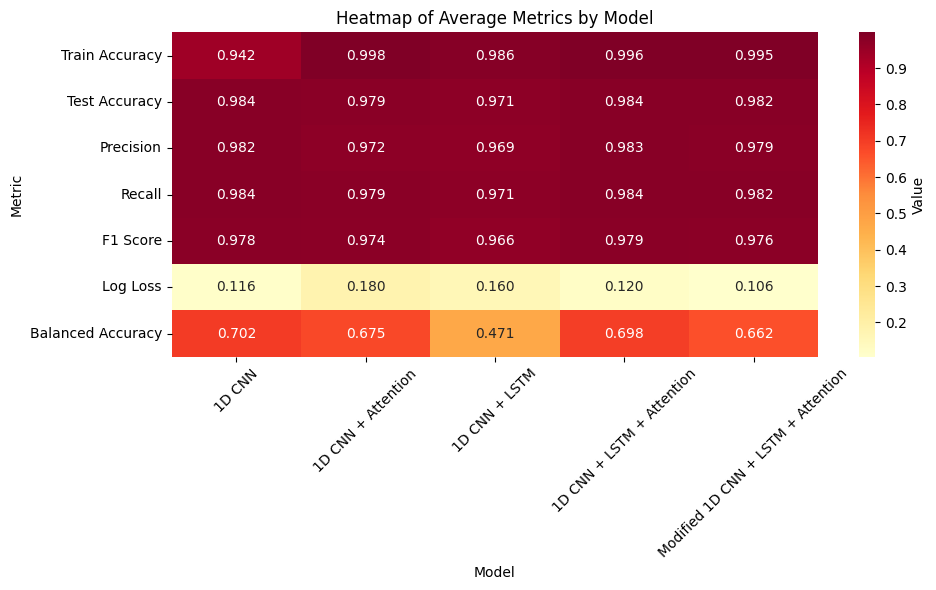

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metric_df.set_index('Model').T, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'Value'})
plt.title('Heatmap of Average Metrics by Model')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylabel('Metric')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

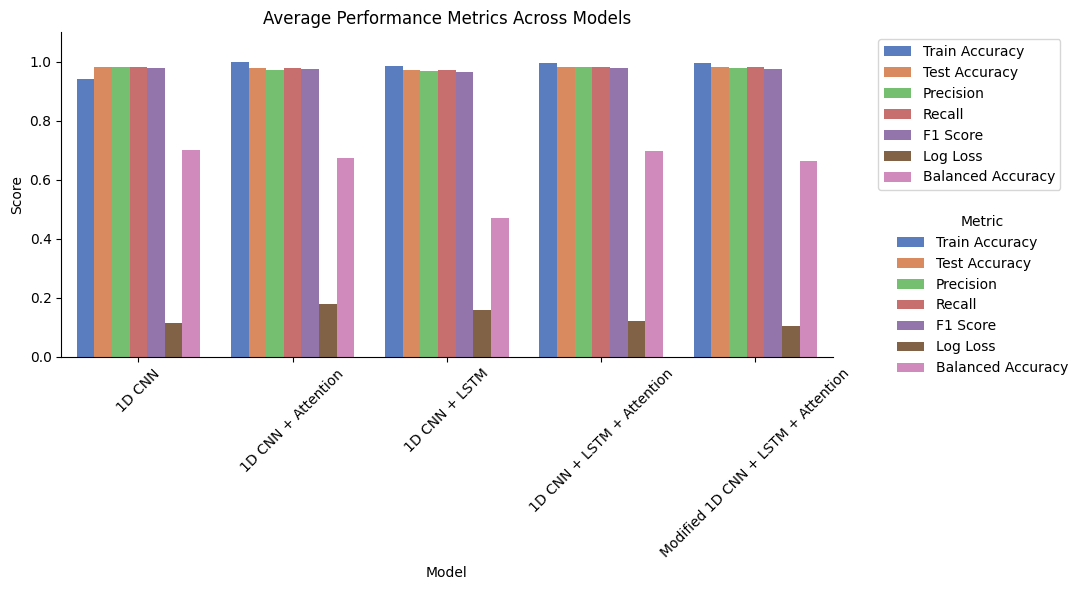

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Melt the DataFrame for easier plotting with seaborn
metric_df_melted = metric_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.catplot(x='Model', y='Value', hue='Metric', kind='bar', data=metric_df_melted, height=6, aspect=1.5, palette='muted')
plt.title('Average Performance Metrics Across Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.1)  # Adjust based on your data range (e.g., log loss might need scaling)
plt.tight_layout()
plt.show()